# EPG Benchmark

We will compare runtime with Sycomore.

In [1]:
%matplotlib inline
        
import numpy as np
import matplotlib.pyplot as plt

def jiang_flip(flip=[35, 43, 70, 45, 27], npulses=1000, delta_flip=5, segment_length=200, n_segments=5, delta_segment=10):
        """
        Sinusoidal pattern as in Jiang SSFP paper.
        """
        # get maximum flip angle
        flip = np.asarray(flip, dtype=np.float32) - delta_flip
        
        # build schedule
        n = np.arange(segment_length, dtype=np.float32) + 1
        rest = np.zeros(delta_segment, dtype=np.float32)
        out = segment = np.concatenate((np.sin(n * np.pi / segment_length) * flip[0], rest))
        
        for i in range(1, n_segments):
            segment = np.concatenate((np.sin(n * np.pi / segment_length) * flip[i], rest))
            out = np.concatenate((out, segment))
            
        return out[:npulses]

# plotting
def display_pattern(input):
    plt.plot(input), plt.xlabel("TR index"), plt.ylabel("flip [deg]")
    plt.xlim([0, len(input)])

def display_signal(input, legend=None, symbol='-', color=None):
    if color is not None:
        plt.gca().set_prop_cycle(plt.cycler("color", color))
    plt.plot(abs(input), symbol)
    plt.xlim([0, len(input)])
    plt.xlabel("TR index")
    plt.ylabel("signal magnitude [a.u.]")
    if legend is not None:
        plt.legend(legend)
    plt.tight_layout()

## Reference implementation

In [2]:
import multiprocess as mp
import time

import sycomore
from sycomore.units import *

def _ssfp_sim(flip, TR, T1, T2):
    # parse 
    npulses = flip.shape[0]

    # initialize spin system
    species = sycomore.Species(T1, T2)

    # initialize model
    model = sycomore.epg.Regular(species, initial_size=10)

    # initialize output
    signal = np.zeros(npulses, dtype=np.complex64)

    # loop over flip angles
    for r in range(2):
        for n in range(npulses):
            # apply rf
            model.apply_pulse(flip[n])
    
            # record signal
            signal[n] = model.echo
    
            # apply relaxation
            model.relaxation(TR)
    
            # shift states
            model.shift()

    return signal
    
def ssfp_sim(flip, TR, T1, T2):

    # sequence parameters
    flip = flip * deg
    TR = TR * ms

    # convert to array  
    T1 = np.atleast_1d(np.asarray(T1)) 
    T2 = np.atleast_1d(np.asarray(T2))

    # broadcast 
    T1, T2 = np.broadcast_arrays(T1, T2)

    # units
    T1 = T1 * ms
    T2 = T2 * ms

    # run
    if len(T1) == 1:
        engine = _ssfp_sim
        t0 = time.time()
        signal = engine(flip, TR, T1[0], T2[0])
        t1 = time.time()
        return signal, t1-t0
    else:
        engine = lambda t1, t2 : _ssfp_sim(flip, TR, t1, t2)
        t0 = time.time()
        with mp.Pool(mp.cpu_count()) as p:
            signal = p.starmap(engine, zip(T1, T2))
        t1 = time.time()
        return np.stack(signal, axis=0), t1-t0
        

## Validation

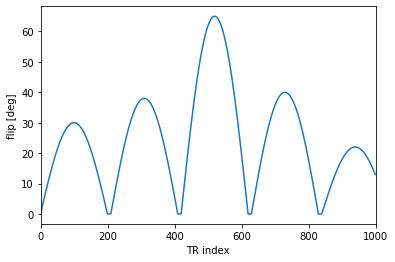

In [6]:
display_pattern(flip)

In [6]:
from deepmr import bloch

# parameters
flip = jiang_flip()
TR = 8.5

T1 = 500.0 # [500.0, 833.0, 2569.0]
T2 = 70.0  # [70.0, 83.0, 329.0]

# computation
sig0, rt0 = ssfp_sim(flip, TR, T1,T2)
sig1, rt1 = bloch.ssfp_sim(flip, TR, T1, T2)

In [7]:
print(rt0)
print(rt1)

0.008776426315307617
1.258648157119751


/tmp/ipykernel_2104703/2682822726.py:38: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


(None, None)

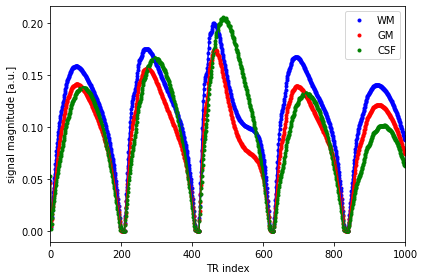

In [4]:
display_signal(sig0.T, color=["b", "r", "g"], symbol='.'), display_signal(sig1.T, color=["b", "r", "g"], symbol='-', legend=["WM", "GM", "CSF"])

## Actual comparison

In [7]:
# define grid of values
T1 = np.linspace(200.0, 1500.0, 65536)
T2 = 50.0

# run sycomore
sig0, runtime0 = ssfp_sim(flip, TR, T1, T2)

# run deepmr
sig1, runtime1 = bloch.ssfp_sim(flip, TR, T1, T2)
sig2, runtime2 = bloch.ssfp_sim(flip, TR, T1, T2, device="cuda:0")


TypeError: Axes.bar_label() missing 1 required positional argument: 'container'

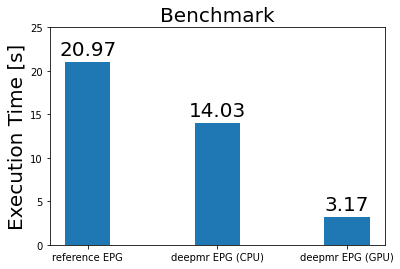

In [12]:
# define labels
labels = ['reference EPG', 'deepmr EPG (CPU)', 'deepmr EPG (GPU)']
runtimes = [round(runtime0, 2), round(runtime1, 2), round(runtime2, 2)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects = ax.bar(x, runtimes, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Execution Time [s]', fontsize=20)
ax.set_title('Benchmark', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0.0, 25.0])

ax.bar_label(rects, padding=3, fontsize=20)
ax.bar_label(padding=3, fontsize=20)

fig.tight_layout()